<a href="https://colab.research.google.com/github/KaziNurUddinRony/gitone/blob/main/DiffusionEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=16d56c49231227b0a2b161cff0019dd3b6c2c22ee35de547492d3f8df7648f6c
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


pyDOE is a Python library for Design of Experiments (DOE). It provides tools to generate various types of experimental designs, which are used to systematically plan and conduct experiments. These designs help in efficiently exploring the effects of multiple variables (factors) on a response (output) while minimizing the number of experiments required.

In [2]:

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())


cpu


# **PyTorch Environment Setup: Explanation**

## **1. Importing Libraries**
The script begins by importing necessary libraries:

- **PyTorch (`torch`)**: For deep learning computations.
- **`torch.autograd`**: Provides automatic differentiation for tensor operations.
- **`torch.nn`**: Defines neural network layers and architectures.
- **`torch.optim`**: Includes optimization algorithms like Stochastic Gradient Descent (SGD) and Adam.
- **Matplotlib (`matplotlib.pyplot`, `gridspec`, `make_axes_locatable`, `Axes3D`, `matplotlib.ticker`)**: Used for data visualization.
- **Scikit-learn (`train_test_split`)**: Splits data into training and test sets.
- **NumPy (`numpy`)**: For numerical operations.
- **`time`**: For measuring execution time.
- **`pyDOE.lhs`**: Latin Hypercube Sampling (LHS) for generating sample points in an efficient manner.
- **`scipy.io`**: For handling `.mat` (MATLAB data) files.

---

## **2. Setting Default Data Type**
```python
torch.set_default_dtype(torch.float)
```
- Sets the default tensor data type to 32-bit floating-point (torch.float32), which balances computational efficiency and precision.

**Tunning Parameter**

In [3]:
steps=20000   #Number of training iterations (epochs)
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000

- `lr = 1e-3`: Learning rate, $\eta= 10^{-3}$, which controls how much the model updates its parameters during training.
- `layers = np.array([2, 32, 32, 1])`:
Defines the architecture of the neural network.
The numbers represent the number of neurons in each layer:
Input Layer: 2 (likely representing spatial coordinate $x$ and time $t$).
Hidden Layers: 32 neurons in each of the two hidden layers.
Output Layer: 1 (presumably predicting a scalar output, such as a function $u(x,t)$.
- `total_points_x = 200`: Discretizes $x$ into 200 points.
- `total_points_t = 100`: Discretizes $t$ into 100 points.

Thus, the total grid points are: $200 \times 100 = 20,000$

This suggests that the solution $u(x,t)$ is defined on a spatiotemporal grid.

- `Nu = 100`: Number of training points.These points likely represent boundary or initial conditions for supervised learning.
- `Nf = 10000`: Number of collocation points.These points enforce the PDE constraint using physics-based loss.

Often, in Physics-Informed Neural Networks (PINNs), collocation points are randomly sampled via Latin Hypercube Sampling (LHS) to approximate the PDE residual.

**Mathematical Explanation for PDE Loss**
If the underlying PDE is: $\mathcal{F}[u(x,t)]=0$
(e.g., a heat equation, wave equation, or Navier-Stokes equation), we approximate it at `Nf` points and include it in the loss function:$\mathcal{L} = \mathcal{L}_{data}+\lambda \mathcal{L}_{PDE}$

where:
- $\mathcal{L}_{data}$
  is the loss on boundary/initial conditions (computed using `Nu` points).
- $\mathcal{L}_{PDE}$  is the PDE residual computed at `Nf` points.
- $\lambda$ is a weighting parameter.

**Auxiliary Functions**

In [4]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

The function `plot3D` is designed to visualize a 3D function $F(x,t)$ using both a contour plot and a surface plot.

- `x`: A tensor representing the spatial coordinate $x$.
- `t`: A tensor representing the time coordinate $t$.
- `y`: The computed function values $F(x,t)$, evaluated at $x$ and $t$.
- `squeeze(1)`: Removes singleton dimensions (i.e., makes sure that x and t are 1D arrays rather than 2D column vectors).
- `x_plot` and `t_plot` are now 1D tensors.
- `ax.contourf(T, X, F_xt, 20, cmap="rainbow")`:

 - Creates a contour plot of $F(x,t)$.
 - `20` specifies the number of contour levels.
 - `cmap="rainbow"` defines the color scheme.
- `plt.axes(projection='3d')`: Creates a 3D figure.
- `ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(), cmap="rainbow")`:
 - Plots a 3D surface where: $x$ is on the y-axis, $t$ is on the x-axis, $F(x,t)$ is on the z-axis.
- `cmap="rainbow"`: Colors the surface plot.


In [5]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

This function visualizes a 3D function $F(x,t)$ using both a contour plot and a surface plot. It is similar to `plot3D`, but here the $x$ and $t$ inputs are already in matrix form (i.e., they are not vectors but full 2D arrays).
- `F_xt` represents function values evaluated at $x$ and $t$, meaning: $F_{i,j}=F(x_i,t_j)$ for all points in the domain.

In [6]:
#exact solution
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


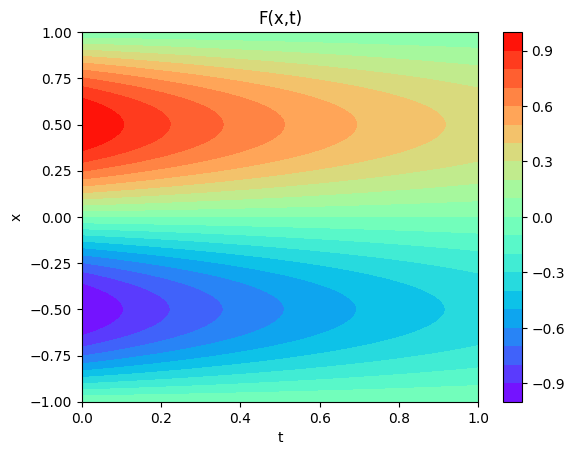

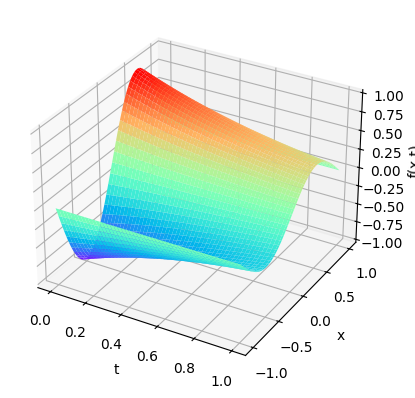

In [7]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X,T)
plot3D(x,t,y_real) #f_real was defined previously(function)

- `torch.linspace(start, end, steps)`: Generates equally spaced points in the given range.

- `view(-1,1)`:Reshapes $x$ and $t$ into column vectors.

In [8]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


**Prepare Data**

In [9]:

# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


This transforms the 2D meshgrid into a 2-column vector, flattens the function values into a column vector, and extracts the domain bounds.

**Mathematical Representation:**

Given: $$X=\begin{bmatrix}
x_1 & x_1 &x_1\\
x_2 & x_2 & x_2\\
x_3 & x_3 & x_3
\end{bmatrix}, T=\begin{bmatrix}
t_1 & t_2 & t_3\\
t_1 & t_2 & t_3\\
t_1 & t_2 & t_3
\end{bmatrix}$$


The result after flattening is:$$x_{test}=\begin{bmatrix}
x_1 & t_1\\
x_1 & t_2\\
x_1 & t_3\\
x_2 & t_1\\
x_2 & t_2\\
x_2 & t_3\\
x_3 & t_1\\
x_3 & t_2\\
x_3 & t_3
\end{bmatrix}$$

This format is required for machine learning models and numerical solvers, which process data in (samples, features) format.

- Given $$y_{real}=\begin{bmatrix}
F(x_1,t_1) & F(x_1,t_2) & F(x_1,t_3)\\
F(x_2,t_1) & F(x_2,t_2) & F(x_2,t_3)\\
F(x_3,t_1) & F(x_3,t_2) & F(x_3,t_3)
\end{bmatrix}$$
- After flattening $$x_{test}=\begin{bmatrix}
F(x_1,t_1)\\
F(x_1,t_2)\\
F(x_1,t_3)\\
F(x_2,t_1)\\
F(x_2,t_2)\\
F(x_3,t_3)\\
F(x_1,t_1)\\
F(x_2,t_2)\\
F(x_3,t_3)
\end{bmatrix}$$

- `lb`: First row of `x_test`, which corresponds to the smallest $x$ and $t$. $$lb=[x_{min} ~~~~~~  t_{min}]$$
- `ub`: Last row of `x_test`, which corresponds to the largest $x$ and $t$.$$ub=[x_{max} ~~~~~~  t_{max}]$$

**Training Data**

In [10]:
#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)
#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)
#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

This prepares training data for a Physics-Informed Neural Network (PINN) by defining:

1. Initial conditions (left boundary)
2. Boundary conditions (bottom and top boundaries)
3. Collocation points (for PDE residual evaluation)

- `X[:,0]`: Extracts the first column (all $x$ values at $t=0$).
- `T[:,0]`: Extracts the first column (which is always 0).
- `X[0,:]`: Extracts the first row (all $t$ values at $x=x_{min}$). Since $u(x_{min},t)=0;~~t_{min}\le t \le t_{max}$
- `T[0,:]`: Extracts the corresponding $t$ values.
- `torch.zeros(bottom_X.shape[0], 1)`: Sets function values to zero.
- `X[-1,:]`: Extracts the last row (all $t$ values at $x=x_{max}$).

- T[-1,:]: Extracts the corresponding $t$ values.
- Here $u(x_{max},t)=0,~~~ 0\le t\le 1$
- Combines all the initial and boundary condition points into a single dataset.

Mathematical Representation:

The input matrix:$$X_{train}=\begin{bmatrix}
x_1 & t_1\\
x_2 & t_2\\
\vdots & \vdots
\end{bmatrix}$$


The output matrix:$$Y_{train}=\begin{bmatrix}
u_1\\
u_2\\
\vdots
\end{bmatrix}$$
- If the boundary/initial data is too large, we select a subset (`Nu`) to speed up training.
- `np.random.choice` selects `Nu` random indices without replacement.
- Selecting Collocation Points for PDE Residual (`Nf` Points):
 - These points are used to enforce the PDE during training.
 - The model does not have function values at these points.
 - Instead, it approximates the PDE residual.
- Latin Hypercube Sampling (LHS):

 - Provides more uniform sampling compared to random sampling.
 - Ensures better coverage of the domain.
 - LHS generates Nf random points $x_i,t_i$ within the domain:
 $$X_{\text{collocation}}= x_{min}+(x_{max}-x_{min})\cdot \text{LHS}_x$$
 $$T_{\text{collocation}}= t_{min}+(t_{max}-t_{min})\cdot \text{LHS}_t$$

- The final training dataset consists of:
 - Boundary/Initial points (`Nu` points) (supervised learning).
 - Collocation points (`Nf` points) (PDE residuals).




In [11]:
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([200, 100]) torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


**Neural Network**

In [12]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t])
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t])
      f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf
    def closure(self):
      optimizer.zero_grad()
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss

This class implements a Physics-Informed Neural Network (PINN) using a fully connected neural network (FCN). The model is trained to solve a Partial Differential Equation (PDE) using two loss terms:

1. Boundary Condition (BC) Loss: Ensures that the network satisfies initial/boundary conditions.
2. PDE Residual Loss: Enforces the underlying physics by minimizing the residual of the PDE.

- The `__init__` function initializes the neural network.
- `nn.ModuleList` is used to store fully connected layers.
- The network is constructed as:
`nn.Linear(layers[i], layers[i+1])` for each pair of consecutive layers.
- Xavier Normal Initialization: $W\sim \left(0, \frac{2}{\text{fan-in}+\text{fan-out}}\right)$

where fan-in is the number of input neurons, and fan-out is the number of output neurons.
Biases are initialized to zero.
**Forward Pass**

- Converts numpy arrays to PyTorch tensors.
- Applies linear transformations and Tanh activations to hidden layers.
- The final layer has no activation, meaning it outputs raw function values.

- Resets gradients before computing the loss.
- Computes total loss and backpropagation.
- Prints training/testing errors every 100 iterations.

**Train Neural Network**

In [13]:
torch.manual_seed(123) #This makes sure that each training run starts with the same initial weights.
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr,
                              max_iter = steps,
                              max_eval = None,
                              tolerance_grad = 1e-05,
                              tolerance_change = 1e-09,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


This initializes the training process for the Physics-Informed Neural Network (PINN). It does the following:

1.Seeds randomness for reproducibility.
2. Moves tensors to the GPU (if available).
3. Initializes the PINN model.
4. Defines an optimizer for training.
- `f_hat` is a zero tensor, representing the target PDE residual that the network should minimize: $F(u)=0$. The function should learn to predict zero PDE residual.

- The L-BFGS optimizer is an alternative to Adam.
- L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) is a second-order optimizer:
 - It approximates the Hessian matrix (second derivatives) using past gradients.
 - This is often used for PINNs since it helps capture sharp gradients.
 - The parameter `line_search_fn='strong_wolfe'` ensures an efficient step size.

**Mathematical Interpretation:**

- Adam updates weights using:$$\theta_{t+1}=\theta_t-\eta \frac{m_t}{\sqrt{v_t}+\epsilon}$$
where $m_t$ and $v_t$ are moving averages of gradients.
- L-BFGS instead solves an optimization subproblem to approximate the next step.

In [14]:
for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
16.872952 --- 0.21578383
0.002315783 --- 0.040029995
0.00094121625 --- 0.037015483
0.00045362493 --- 0.036334444
0.00022514918 --- 0.03617128
0.00013598034 --- 0.03615725
0.0002570636 --- 0.035925392
8.711062e-05 --- 0.03609104
7.8976256e-05 --- 0.0360808
7.727009e-05 --- 0.036078706


**Plots**

In [15]:
y1=PINN(X_test)

In [16]:
x1=X_test[:,0]
t1=X_test[:,1]

In [17]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

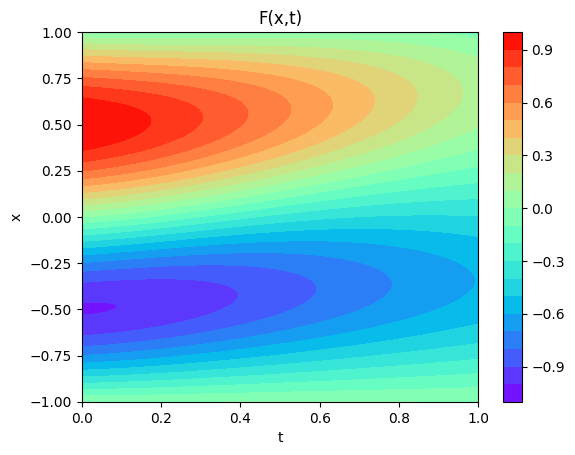

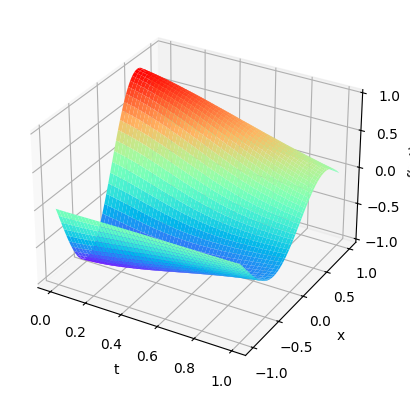

In [18]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

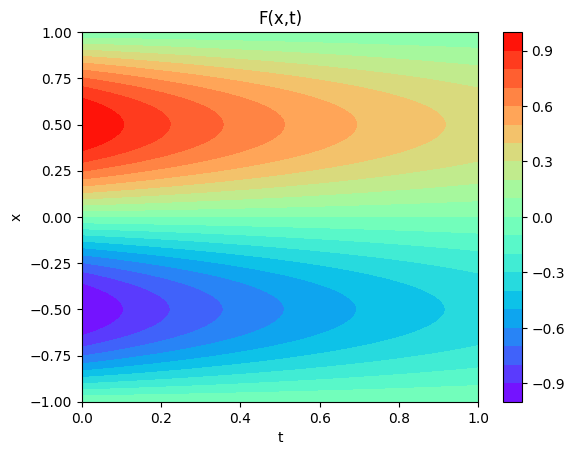

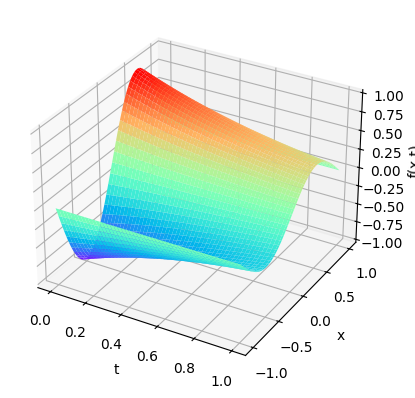

In [19]:
plot3D_Matrix(X,T,y_real)